In [1]:
%logstop
%logstart -ortq ~/.logs/ML_Clustering.py append
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Clustering

Clustering is a branch of unsupervised machine learning where the goal is to identify groups or clusters in your data set without the use of labels. Clustering should not be considered the same as classification; we are not trying make predictions on observations from a set of classes. In clustering, you are identifying a set of similar data points and calling the resulting set a cluster.

Let's consider an example of clustering. You may have a data set characterizing your customers like demographic information and personal preferences. A supervised machine learning application would be to determine whether a person will buy a product. However, an _unsupervised_ machine learning application would be to identify several groups or types of customers. With these groups identified, you can analyze the groups and build profiles describing the groups. For example, one group tends to include people from the ages 20 to 25 who like the outdoors. With these profiles, you can pass that information and analysis to the marketing team to create different advertisements to best attract each group.

In this notebook, we will discuss clustering metrics and two common algorithms for clustering. In the code below, we demonstrate the result of determining three clusters in a data set.

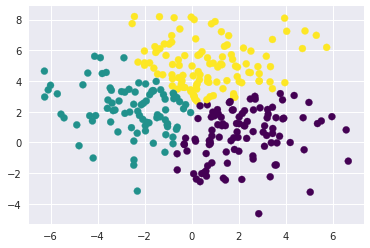

In [3]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# generate data
X, _ = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=2, random_state=0)

# fit cluster model and assign points to clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
clusters = kmeans.predict(X)

plt.scatter(*X.T, c=clusters, cmap='viridis');

In `scikit-learn`, clustering models have the same interface as predictors, albeit they do not make predictions in the same sense as classifiers but rather perform assignments. To train a clustering model object with data set `X`, simply invoke the `fit(X)`. To assign clusters, use `predict(X)`.

## Metrics for clustering

Because clustering is unsupervised learning, we cannot rely on metrics based on labels; there is not a right or wrong answer. However, it is still possible to derive metrics to evaluate the performance of clustering algorithms. More care and analysis will be required when comparing multiple clustering results due to the nature of the derived metrics. Previously in supervised machine learning, we could objectively say one model will perform better because it has a lower test error.

Two common metrics for clustering are

1. **Inertia**: the within cluster sum of square distance
1. **Silhouette Coefficient**: a measure of how dense and separated are the clusters

Mathematically, inertia is equal to

$$ \sum_{k} \sum_{X_j \in  C_k} \| X_j  - \mu_k \|^2, $$

where $\mu_k$ is the centroid of cluster $k$ and $C_k$ is the set of points assigned to cluster $k$. Basically, the inertia is the sum of the distance of each point to the centroid or center of its assigned cluster. A lower inertia means the points assigned to the clusters are closer to the centroid.

The silhouette coefficient is a property assigned to each data point. It is equal to

$$ \frac{b - a}{\max(a, b)}, $$

where $a$ is the distance between a point and centroid of its assigned cluster and $b$  is the distance between the point and the centroid of the nearest neighboring cluster (i.e. the closest cluster the point is not assigned to). The silhouette coefficient ranges from -1 to 1. If a point is really close to the centroid of its assigned cluster, then $a \ll b$ and the silhouette coefficient will be approximately equal to 1. If the reverse is true, $a \gg b$, then the coefficient will be -1. If the point could have been assigned to either cluster, its coefficient will be 0. Maximizing the silhouette coefficient will prioritize dense and highly separated clusters as dense clusters will have a low $a$ value and having clusters well separated from each other will increase $b$.

## $K$-Means Clustering

The $K$-means algorithms seeks to find $K$ clusters within a data set. The clusters are chosen to reduce the inertia; the objective function is

$$ \min_{C_k} \sum_{k} \sum_{X_j \in  C_k} \| X_j  - \mu_k \|^2. $$

The centroid of a cluster $\mu_k$ is equal to

$$ \mu_k = \frac{1}{|C_k|} \sum_{X_j \in C_k} X_j, $$

where $|C_k|$ is the number of points in cluster $k$. The equation says that the components of the centroid are equal to _mean_ of each feature/components of all points assigned to the cluster, hence the name of the algorithm. The training algorithm for $K$-means is straight-forward. After seeding the algorithm, choosing the starting locations of each cluster's centroid,

1. Assign each point to a cluster based on which cluster centroid it's the closest to
1. Calculate the centroid of resulting cluster using the points that have been assigned to the cluster
1. Repeat the above steps until convergence is met

Let's create an interactive plot that allows users to walk through the iterations involved in the algorithm.

In [4]:
from ipywidgets import interact

def plot_kmeans_steps(X, n_clusters, seeds=np.array([[0, 4], [4, 2], [-2, 4]])):
    def func(step=0):
        iters = step // 2
        
        if iters:
            kmeans = KMeans(n_clusters=n_clusters, max_iter=iters, n_init=1, init=seeds)
            kmeans.fit(X)
            centroids = kmeans.cluster_centers_
            labels = kmeans.labels_
        else:
            centroids = seeds
            labels = '0.5'
        if step % 2:
            kmeans = KMeans(n_clusters=n_clusters, max_iter=iters+1, n_init=1, init=seeds)
            kmeans.fit(X)
            labels = kmeans.labels_
        
        plt.scatter(*X.T, c=labels, cmap='viridis', alpha=0.5)
        plt.scatter(*centroids.T, c=range(n_clusters), cmap='viridis', marker='*', s=150, 
                    linewidths=1, edgecolors='k')
        plt.title(['Set Centroids', 'Assign Clusters'][step % 2])
    
    return func

interact(plot_kmeans_steps(X, n_clusters=3), step=(0, 10));

interactive(children=(IntSlider(value=0, description='step', max=10), Output()), _dom_classes=('widget-interac…

### Implementation details

There are several thing to keep in mind about the $K$-means algorithm. While the algorithm is guaranteed to converge, it will not converge to the _global_ minimum. It is a greedy algorithm; it is relatively quick to run but we are at risk of obtaining a suboptimal solution. Different starting positions will result in different solutions. To counteract suboptimal solutions, `KMeans` by default runs the algorithm ten times and chooses the best result. The number of runs is controlled by `n_init`. The algorithm for the initial centroid locations is controlled by the keyword `init`; the default is `'kmeans++'` which has been shown to work well and results in faster convergence. You can read more about the `kmeans++` algorithm [here](https://en.wikipedia.org/wiki/K-means%2B%2B).

**Questions**
* What is the general behavior of the inertia as we increase the number of clusters?
* Is it important to scale our data set when using $K$-means? If so, what `scikit-learn` tool would we use?

## Choosing the number of clusters

The number of clusters is a hyperparameter to clustering models; it is set prior to training. How does one choose the optimal number of clusters? We expect as we use more clusters to group our observations the inertia goes down because the points will be closer to the cluster's centroid. What is the inertia when the number of clusters is equal to the number of observations? If every point is its own cluster, the inertia is zero. Choosing the number of clusters that yields the lowest inertia results in a meaningless solution. Instead, we need identify at what point is increasing the number of clusters no longer resulting in an appreciable drop in inertia (the point of "diminishing returns"). Identifying this region is accomplished using an \"elbow plot\", named because the graph looks like a bent arm. Let's construct an elbow plot with the California housing data set.

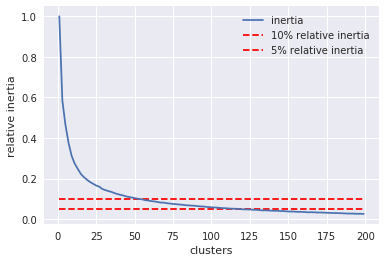

In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# import and shuffle the data
data = fetch_california_housing()
X = data['data']
X_shuffled = shuffle(X, random_state=0)

scaler = StandardScaler() # need to scale data to make kmeans work properly
Xt = scaler.fit_transform(X_shuffled[:500]) # down sample for speed
n_clusters = range(1, 200, 2)
inertia = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(Xt)
    inertia.append(kmeans.inertia_)

plt.plot(n_clusters, inertia/inertia[0])
plt.hlines(0.1, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
plt.hlines(0.05, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
plt.xlabel('clusters')
plt.ylabel('relative inertia')
plt.legend(['inertia', '10% relative inertia', '5% relative inertia']);

The elbow plot shows us that there is little drop in inertia after about 50 or 100 clusters with most of the drop occurring before 25. As discussed earlier, one cannot look at this plot and definitely say whether using 50 clusters is better than using 100 clusters. Instead, we justify our choice of cluster size given the analysis and understand there is some arbitrariness in the decision. Further, rarely do machine learning problems exist in a bubble; there are constraints usually imposed by business and financial considerations. For example, in the clustering of our consumer data for advertisement purposes, it may only be financially practical to identify no more than 10 groups.

## Elongated clusters

Consider applying $K$-means to a data set where points are clustered in elongated shapes. We can visualize the data  and manually identify the clusters. Let's see what happens when we try to use $K$-means with a data set consisting points arranged in elongated shapes.

In [6]:
def elongated(clustering=None):
    X, _ = make_blobs(n_samples=300, n_features=2, cluster_std=0.5, random_state=0)

    # elongate the data
    Xt = np.dot(X, [[0.6, -0.64], [-0.4, 0.9]])

    if clustering is None:
        plt.scatter(*Xt.T, cmap='viridis')
    else:
        kmeans = KMeans(n_clusters=3)
        kmeans.fit(Xt)
        clusters = kmeans.predict(Xt)
        plt.scatter(*Xt.T, c=clusters, cmap='viridis');
        
interact(elongated, clustering=[None, 'kmeans']);

interactive(children=(Dropdown(description='clustering', options=(None, 'kmeans'), value=None), Output()), _do…

$K$-means did not identify what we would consider are the obvious clusters in the data set. Remember, the clusters are chosen to reduce inertia, which is a measure of how coherent the clusters are, resulting in isotropic clusters.

## Gaussian mixture models

Gaussian mixture models are an alternative to the $K$-means clustering. As seen previously, it fails to define clusters of elongated shapes. Gaussian mixture models offer additional capabilities compared to $K$-means. Cluster definitions are probabilistic and it can model elongated shapes. Gaussian mixture models define a probability density function over the feature space defined by adding or "mixing" several multivariate Gaussians. 

To understand Gaussian mixture models, let's first define and plot a multivariate Gaussian. A multivariate Gaussian is simply a Gaussian distribution for more than one dimension. As with the one dimensional Gaussian, it has two parameters. The mean $\mu_i$ is now a vector since we have multiple dimensions and the variance has been replaced with the **covariance** matrix. Not only does the covariance matrix controls how spread out the distribution is but also how correlated the variables are. If the variables are highly correlated, then the distribution will looked stretched. The covariance matrix contains all possible pair-wise covariance values for all variables. For a two dimensional case the covariance matrix has three different parameters, the variance of each variable, $\sigma^2_{x}$ and $\sigma^2_{y}$ and the covariance between the two variables $\mathrm{cov}(x, y)$.

$$ \Sigma = \left[ \begin{array}{cc} 
\sigma^2_{x} & \mathrm{cov}(x, y) \\
\mathrm{cov}(x, y) & \sigma^2_{y} \\
\end{array} \right]$$

Let's build an interactive plot where we can see the effect of modifying the covariance matrix for a bivariate Gaussian. We can adjust all three parameters involved in the covariance matrix. Note, the correlation coefficient $\rho$ is just a normalization of the covariance. In this case, it is equal to $\rho = \mathrm{cov}(x, y)/ (\sigma_{x} \sigma_{y})$.

In [7]:
from ipywidgets import FloatSlider
import scipy as sp

def multivariate_gaussian(corr=0, sigma_x=1, sigma_y=1):
    cov = sigma_x*sigma_y*np.array([[sigma_x/sigma_y, corr], [corr, sigma_x/sigma_y]])
    dist = sp.stats.multivariate_normal(mean=[0, 0], cov=cov)
    X = dist.rvs(1000, random_state=0)
    
    n = 100
    xlims = [-4, 4]
    ylims = [-4, 4]
    X1, X2 = np.meshgrid(np.linspace(*xlims, n), np.linspace(*ylims, n))
    proba = dist.pdf(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))))
    
    plt.scatter(*X.T, alpha=0.25)
    plt.contour(X1, X2, proba.reshape(100, 100))
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel('$x$')
    plt.ylabel('$y$')

corr_slider = FloatSlider(min=-0.99, max=0.99, value=0., step=0.01, description='$\\rho$')
sigma_x_slider = FloatSlider(min=0.5, max=1.5, value=1., step=0.01, description='$\sigma_x$')
sigma_y_slider = FloatSlider(min=0.5, max=1.5, value=1., step=0.01, description='$\sigma_y$')
interact(multivariate_gaussian, corr=corr_slider, sigma_x=sigma_x_slider, sigma_y=sigma_y_slider);

interactive(children=(FloatSlider(value=0.0, description='$\\rho$', max=0.99, min=-0.99, step=0.01), FloatSlid…

Notice how the covariance matrix controls the elongation of the distribution. It is this "stretching" capability that enables Gaussian mixture models to create anisotropic clusters. The probability across our feature space is defined as

$$ p(x_j) = \sum_k \phi_k \mathcal{N}(x_j; \mu_k, \Sigma_k), $$

where $\mathcal{N}(x_j; \mu_k, \Sigma_k)$ is a multivariate Gaussian parameterized by $\mu_k$ and $\Sigma_k$. When we fit a mixture model to a training set, we are trying to determine $\phi_k$, $\mu_k$, and $\Sigma_k$ that will maximize the likelihood function

$$ L(\phi_k, \mu_k, \Sigma_k) =  \prod_j p(x_j).$$

The most common algorithm used to fit Gaussian mixture models is the expectation-maximization algorithm, a two step iterative scheme. More about the algorithm can be read [here]( https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm). As with complicated models, the additional complexity results in slower training times and Gaussian mixture models will be difficult to train with large data sets.

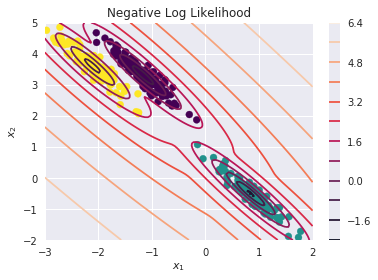

In [8]:
from sklearn.mixture import GaussianMixture

X, _ = make_blobs(n_samples=300, n_features=2, cluster_std=0.5, random_state=0)
Xt = np.dot(X, [[0.6, -0.64], [-0.4, 0.9]])

gm = GaussianMixture(n_components=3, covariance_type='full')
gm.fit(Xt)
clusters = gm.predict(Xt)

xlims = [-3, 2]
ylims = [-2, 5]
X1, X2 = np.meshgrid(np.linspace(*xlims, 100), np.linspace(*ylims, 100))
proba = gm.score_samples(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))))

plt.contour(X1, X2, np.log(-proba.reshape(100, 100)), 10)
plt.colorbar()
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(*Xt.T, c=clusters, cmap='viridis')
plt.title('Negative Log Likelihood');

## Exercises

1. The silhouette coefficient can also be used for choosing the number of clusters. `scikit-learn` has a function to calculate the silhouette coefficient: `from sklearn.metrics import silhouette_score`. Compare the silhouette coefficient as a function of number of clusters with the elbow plot displayed in the notebook.

1. For the California housing data, create an elbow plot using Gaussian mixture models. What would be good choice of the number of clusters. How does the training time compare with $K$-means?

*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*